In [1]:
#========================================================================
# Copyright 2019 Science Technology Facilities Council
# Copyright 2019 University of Manchester
#
# This work is part of the Core Imaging Library developed by Science Technology	
# Facilities Council and University of Manchester
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0.txt
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# 
#=========================================================================

## Tikhonov regularisation using CGLS and block framework
Few lines intro

**Learning objectives:**
1. Construct and manipulate BlockOperators and BlockDataContainer, including direct and adjoint operations and algebra.
2. Use Block Framework to solve Tikhonov regularisation with CGLS algorithm.
3. Apply Tikhonov regularisation to tomographic reconstruction and explain the effect of regularization parameter and operator in regulariser.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from ccpi.framework import ImageGeometry, ImageData 
from ccpi.framework import AcquisitionGeometry, AcquisitionData
from ccpi.framework import BlockDataContainer
from ccpi.framework import TestData

from ccpi.optimisation.algorithms import CGLS
from ccpi.optimisation.operators import BlockOperator, Gradient, Identity, FiniteDiff

from ccpi.astra.operators import AstraProjectorSimple 

import tomophantom
from tomophantom import TomoP2D
import scipy
import numpy as np    

import matplotlib.pyplot as plt

from utilities import plotter2D

import os

### Setting up the dataset - 2D

In [3]:
#set up acquisition geometry
number_pixels_x = 1024
number_projections = 180
angles = np.linspace(0, np.pi, number_projections, dtype=np.float32)
ag = AcquisitionGeometry(geom_type='parallel', dimension='2D', angles=angles, pixel_num_h=number_pixels_x)

#set up image geometry
num_voxels_xy = 1024
ig = ImageGeometry(voxel_num_x = num_voxels_xy, voxel_num_y = num_voxels_xy)

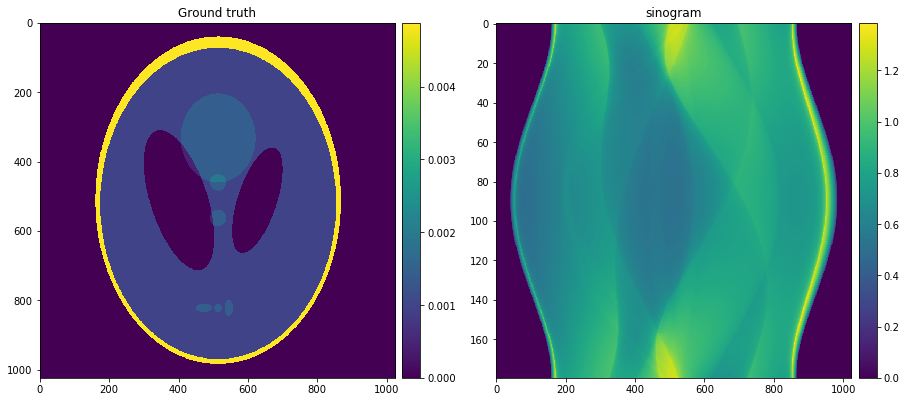

In [4]:
# Load Shepp-Logan phantom 
model = 1
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

#tomophantom takes angular input in degrees
phantom_2D = TomoP2D.Model(model, num_voxels_xy, path_library2D)
phantom_sino = TomoP2D.ModelSino(model, num_voxels_xy, number_pixels_x, angles*180./np.pi, path_library2D)

#rescale the tomophantom data, set the max absoobtion to 25%
set_ratio_absorption = 0.25
new_max_value = -np.log(set_ratio_absorption)
sino_max = np.amax(phantom_sino)
scale = new_max_value/sino_max

#allocate the image data container and copy the dataset in
#this is only used as a reference to the ground truth
model = ig.allocate(0)
model.fill(phantom_2D*scale)

#allocate the acquisition data container and copy the sinogram in
sinogram = ag.allocate(0)
sinogram.fill(phantom_sino*scale)

plots = [model, sinogram]
titles = ["Ground truth", "sinogram"]
plotter2D(plots,titles,fix_range=False, stretch_y=True)

In [5]:
#add poisson noise to the sinogram
background_counts = 500 #lower counts will increase the noise
counts = float(background_counts) * np.exp(-sinogram.as_array())
noisy_counts = np.random.poisson(counts)
sino_out = -np.log(noisy_counts/background_counts)

sinogram_noisy = ag.allocate()
sinogram_noisy.fill(sino_out)

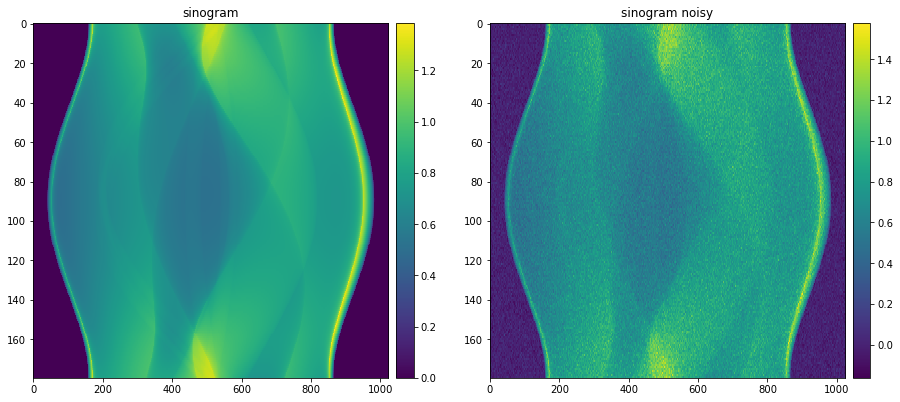

In [6]:
plots = [sinogram, sinogram_noisy]
titles = ["sinogram", "sinogram noisy"]
plotter2D(plots,titles,fix_range=False, stretch_y=True)

<a id="section_CGLS_simple"></a>
### Reconstruct using unregularised CGLS

Solve:
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2$$

where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the solution



In [7]:
#define the operator A
device = "gpu"
operator = AstraProjectorSimple(ig, ag, device)

In [8]:
#define the data b
data = sinogram_noisy

In [9]:
#setup CGLS
x_init = ig.allocate(0)
cgls_simple = CGLS(x_init=x_init, operator=operator, data=data, update_objective_interval = 10)
cgls_simple.max_iteration = 1000

CGLS setting up
CGLS configured


In [10]:
#run the algorithm
cgls_simple.run(100, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          9.20408e+04
       10       1000         0.025          9.25623e+03
       20       1000         0.025          2.66005e+02
       30       1000         0.025          7.24741e+01
       40       1000         0.023          5.03150e+01
       50       1000         0.023          4.70630e+01
       60       1000         0.024          4.62706e+01
       70       1000         0.026          4.59839e+01
       80       1000         0.025          4.57948e+01
       90       1000         0.023          4.55865e+01
      100       1000         0.025          4.54035e+01


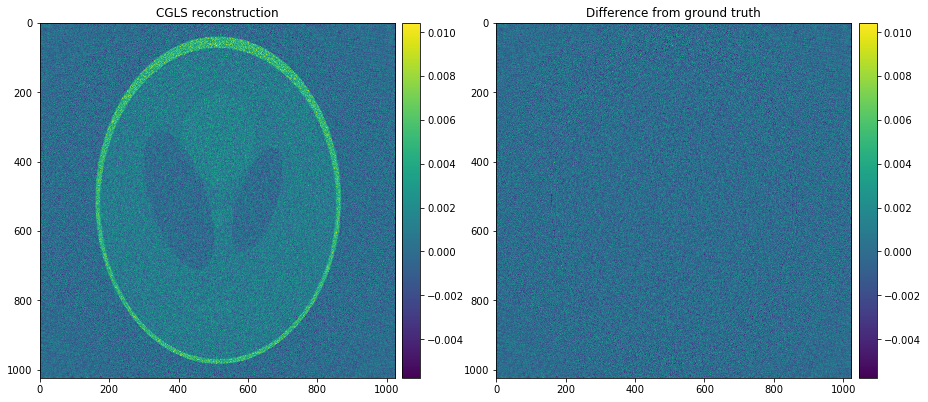

In [11]:
#plot the results
CGLS_simple_output = cgls_simple.get_output()

plots = [CGLS_simple_output, CGLS_simple_output - model]
titles = ["CGLS reconstruction","Difference from ground truth" ]
plotter2D(plots,titles,fix_range=True)

<span style="color:red;font-size:larger">**Exercise 1:**</span> Repeat this with the noisy dataset. Remember you can change the number of iteations to run between outputs. [go to section start](#section_CGLS_simple)

### Reconstruct using regularised CGLS

#### Regularisation

Noisy datasets lead to an ill-posed problem. If we try to solve these using LS we end up with a noisy reconstruction. Regularisation adds information in order for us to solve the problem.

#### CGLS and regularisation

Adding a differentiable regulariser...

Identity

gradient



Solve:
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b \end{Vmatrix}^2_2 + \alpha^2\|Lu\|^2_2$$


where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the solution

- $\alpha$ is the regularisation parameter

- $L$ is a regularisation operator

<br>This can be re-written in the form:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\binom{A}{\alpha L} u - \binom{b}{0}\end{Vmatrix}^2_2$$

Which allows us to solve it using CGLS in the form:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{b}\end{Vmatrix}^2_2$$

where:

- $\tilde{A} = \binom{A}{\alpha L}$

- $\tilde{b} = \binom{b}{0}$



#### Introducing the block framework

We can construct $\tilde{A}$ and $\tilde{b}$ using the BlockFramework in the CIL.

$\tilde{A}$ is a BlockOperator

`BlockOperator(op0,op1,shape=(1,2))` results in a row block


`BlockOperator(op0,op1)`
and
`BlockOperator(op0,op1,shape=(2,1))` result in a column block

$\tilde{b}$ is a BlockDataContainer

`BlockDataContainer(DataContainer0, DataContainer1)`


<a id="section_CGLS_alpha"></a>
#### Reconstruct using CGLS and the identity operator

The identity opeator blah blah

<span style="color:red;font-size:larger">**Exercise #:**</span> Construct the BlockOperator $\tilde{A}$ using the idenity operator

In [12]:
#define the operator A
device = "gpu"
A = AstraProjectorSimple(ig, ag, device)
L = Identity(ig)
alpha = 30

#operator_block = BlockOperator(  )
operator_block = BlockOperator( A, alpha * L)

In [13]:
#define the data b
data_block = BlockDataContainer(sinogram_noisy, L.range_geometry().allocate(0))

Run CGLS as before, but passing the BlockOperator and BlockDataContainer

In [14]:
#setup CGLS with the Block Operator and Block DataContainer
x_init = ig.allocate(0)      
cgls_regularised = CGLS(x_init=x_init, operator=operator_block, data=data_block, update_objective_interval = 10)
cgls_regularised.max_iteration = 1000

CGLS setting up
CGLS configured


In [15]:
#run the algorithm
cgls_regularised.run(100, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          9.20408e+04
       10       1000         0.031          9.68347e+03
       20       1000         0.030          1.63741e+03
       30       1000         0.030          1.61211e+03
       40       1000         0.030          1.61161e+03
       48       1000         0.030          1.61160e+03
Tolerance is reached: 1e-06


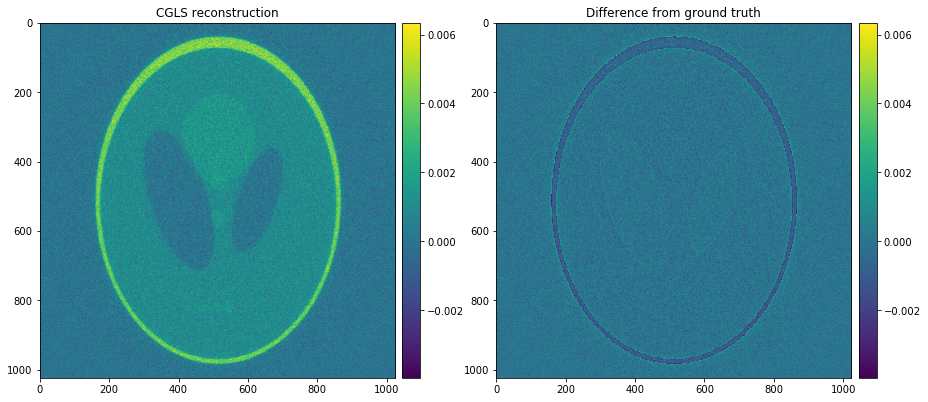

In [16]:
#plot the results
CGLS_regularised_output = cgls_regularised.get_output()

plots = [CGLS_regularised_output, CGLS_regularised_output - model]
titles = ["CGLS reconstruction","Difference from ground truth" ]
plotter2D(plots,titles,fix_range=True)

<span style="color:red;font-size:larger">**Exercise #:**</span> Repeat this with different regularisation weights [go to section start](#section_CGLS_alpha)

### A more detailed look at the BlockFramework

#### BlockDataContainer 

BlockDataContainer holds datacontainers as a column vector

$$x = [x_{1}, x_{2} ]\in (X_{1}\times X_{2})$$
$$y = [y_{1}, y_{2}, y_{3} ]\in(Y_{1}\times Y_{2} \times Y_{3})$$


#### BlockOperator: 

A Block matrix with operators 

$$ K = \begin{bmatrix}
A_{1} & A_{2} \\
A_{3} & A_{4} \\
A_{5} & A_{6}
\end{bmatrix}_{(3,2)} *  \quad \underbrace{\begin{bmatrix}
x_{1} \\
x_{2} 
\end{bmatrix}_{(2,1)}}_{\textbf{x}} =  \begin{bmatrix}
A_{1}x_{1}  + A_{2}x_{2}\\
A_{3}x_{1}  + A_{4}x_{2}\\
A_{5}x_{1}  + A_{6}x_{2}\\
\end{bmatrix}_{(3,1)} =  \begin{bmatrix}
y_{1}\\
y_{2}\\
y_{3}
\end{bmatrix}_{(3,1)} = \textbf{y}$$

Column: Share the same domains $X_{1}, X_{2}$<br>
Rows: Share the same ranges $Y_{1}, Y_{2}, Y_{3}$

$$ K : (X_{1}\times X_{2}) \rightarrow (Y_{1}\times Y_{2} \times Y_{3})$$


$$ A_{1}, A_{3}, A_{5}: \text{share the same domain }  X_{1}$$
$$ A_{2}, A_{4}, A_{6}: \text{share the same domain }  X_{2}$$

$$A_{1}: X_{1} \rightarrow Y_{1}, \quad A_{3}: X_{1} \rightarrow Y_{2}, \quad  A_{5}: X_{1} \rightarrow Y_{3}$$
$$A_{2}: X_{2} \rightarrow Y_{1}, \quad A_{4}: X_{2} \rightarrow Y_{2}, \quad  A_{6}: X_{2} \rightarrow Y_{3}$$

##### An example: The gradient operator

The gradient operator uses BlockDataContainers. ??ToDo: implement gradient as block of FD? or just leave as it is?

The direct gradient operator $\nabla$ acts on an image $u$ and returns a BlockDataContainer $\textbf{y}$

$$ \nabla(u) = 
\begin{bmatrix}
   \nabla_x\\
   \nabla_y\\
\end{bmatrix}
*u =
\begin{bmatrix}
    \nabla_xu\\
    \nabla_yu\\
\end{bmatrix}
=  
\begin{bmatrix}w_{x}\\w_{y}\end{bmatrix}= \textbf{w}$$

The adjoint gradient operator $\nabla^*$ acts on the BlockDataContainer $\textbf{y}$ and returns an image $\rho$

$$  \nabla^*(\textbf w) = 
\begin{bmatrix}
    \nabla^*_x &
    \nabla^*_y
\end{bmatrix}
*
\begin{bmatrix}
    w_{x}\\
    w_{y}\\
\end{bmatrix} 
=
\begin{bmatrix}
    \nabla^*_x w_x + \nabla^*_y w_y
\end{bmatrix} =  \rho$$

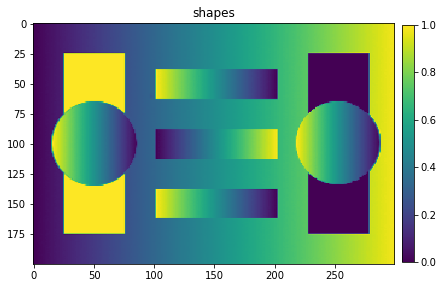

In [17]:
#loading new test image
loader = TestData()
shapes = loader.load(TestData.SHAPES)
shapes_ig = shapes.geometry

#plot ths results
plotter2D(shapes, "shapes")

Define the gradient as the FD

Introduce the Finite Difference opearator

`from ccpi.optimisation.operators import FiniteDiff`

set it up in x and y

Setting up and running the FD operator

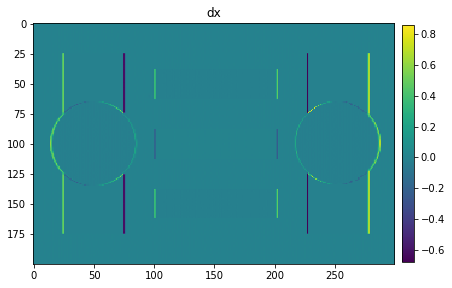

In [18]:
#define the operator FiniteDiff - needs to image geometry, the direction and the boundary conditions
fdx = FiniteDiff(shapes_ig, direction=1, bnd_cond='Neumann')

#run it over the input image
image_2D_dx = fdx.direct(shapes)

#plot ths results
plotter2D(image_2D_dx, "dx")

<span style="color:red;font-size:larger">**Exercise #:**</span> Create a blockOperator to calculate the finite difference in x and y

In [19]:
#define the directions and boundary conditions
fdx = FiniteDiff(shapes_ig, direction=1, bnd_cond='Neumann')
fdy = FiniteDiff(shapes_ig, direction=0, bnd_cond='Neumann')

In [20]:
#comstruct the block operator
FD = BlockOperator(fdx, fdy)

In [21]:
#run it on the test image
fd_out = FD.direct(shapes)

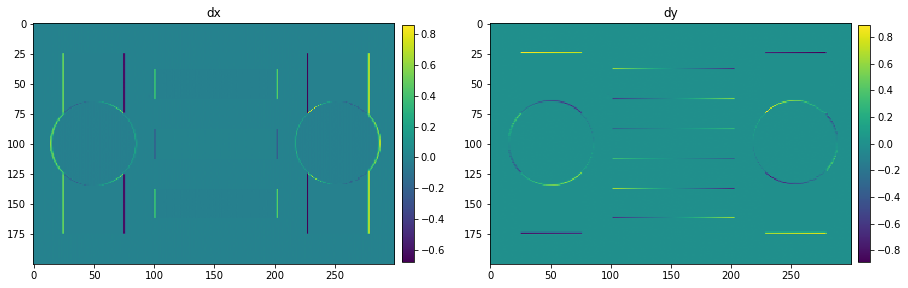

In [22]:
#plot the results
plots = [fd_out.get_item(0), fd_out.get_item(1)]
titles = ["dx","dy" ]
plotter2D(plots,titles)

A closer look at data types

In [23]:
#input is ImageData
print("Input")
print("\ttype:\t", type(shapes))
print("\tshape:\t", shapes.shape)

Input
	type:	 <class 'ccpi.framework.framework.ImageData'>
	shape:	 (200, 300)


In [24]:
#output is BloackDataContainer
print("Output")
print("\ttype:\t", type(fd_out))
print("\tshape:\t", fd_out.shape)

print("\tDataContainer 0")
print("\t\ttype:\t", type(fd_out.get_item(0)))
print("\t\tshape:\t", fd_out.get_item(0).shape)

print("\tDataContainer 1")
print("\t\ttype:\t", type(fd_out.get_item(1)))
print("\t\tshape:\t", fd_out.get_item(1).shape)

Output
	type:	 <class 'ccpi.framework.BlockDataContainer.BlockDataContainer'>
	shape:	 (2, 1)
	DataContainer 0
		type:	 <class 'ccpi.framework.framework.ImageData'>
		shape:	 (200, 300)
	DataContainer 1
		type:	 <class 'ccpi.framework.framework.ImageData'>
		shape:	 (200, 300)


In [25]:
#split containers
dx = fd_out.get_item(0)
dy = fd_out.get_item(1)

#calculate the squared norm of the x and y gradients
dx2 = (dx**2).sum()
dy2 = (dy**2).sum()
sq_norm = dx2 + dy2
print(sq_norm)

489.45068


In [26]:
#do the same thing within the blockframework
sq_norm = fd_out.squared_norm()
print(sq_norm)

489.45038


The BlockFramework provides basic algebra between BlockDataContainers, DataContainers, subclasses and scalars providing the shape of the containers are compatible
- add
- subtract
- multiply
- divide
- power
- squared_norm

<span style="color:red;font-size:larger">**Exercise #:**</span> Run the adjoint operator. What data type does it take in and write out?


(200, 300)


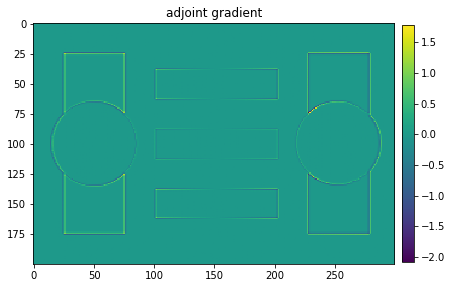

In [27]:
#run the adjoint method
adjoint_output = FD.adjoint(fd_out)

plotter2D(adjoint_output, "adjoint gradient")

print(adjoint_output.shape)

### Reconstruct using regularised CGLS with Tikhonov regularisation

#### Tikhonov regularisation

$$ \underset{x}{\mathrm{argmin}}\begin{Vmatrix}A u - b \end{Vmatrix}^2_2 + \alpha^2\begin{Vmatrix}\nabla u\end{Vmatrix}^2_2$$

For this use the gradient operator. And optimised form of FD over the space or space+time dimensions.

In [28]:
#define the operator A
device = "gpu"
A = AstraProjectorSimple(ig, ag, device)
L = Gradient(ig)
alpha = 75

operator_block = BlockOperator( A, alpha * L, shape=(2,1))

In [29]:
#define the data b
data_block = BlockDataContainer(sinogram_noisy, L.range_geometry().allocate(0))

In [30]:
#setup CGLS with the block operator and block data
x_init = ig.allocate(0)      
cgls_tikhonov = CGLS(x_init=x_init, operator=operator_block, data=data_block, update_objective_interval = 10)
cgls_tikhonov.max_iteration = 1000

CGLS setting up
CGLS configured


In [31]:
#run the algorithm
cgls_tikhonov.run(100, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          9.20408e+04
       10       1000         0.042          9.25642e+03
       20       1000         0.042          7.23416e+02
       30       1000         0.042          7.11033e+02
       40       1000         0.042          7.10943e+02
       50       1000         0.042          7.10928e+02
       60       1000         0.042          7.10924e+02
       70       1000         0.042          7.10923e+02
       80       1000         0.042          7.10922e+02
       90       1000         0.042          7.10922e+02
      100       1000         0.042          7.10921e+02


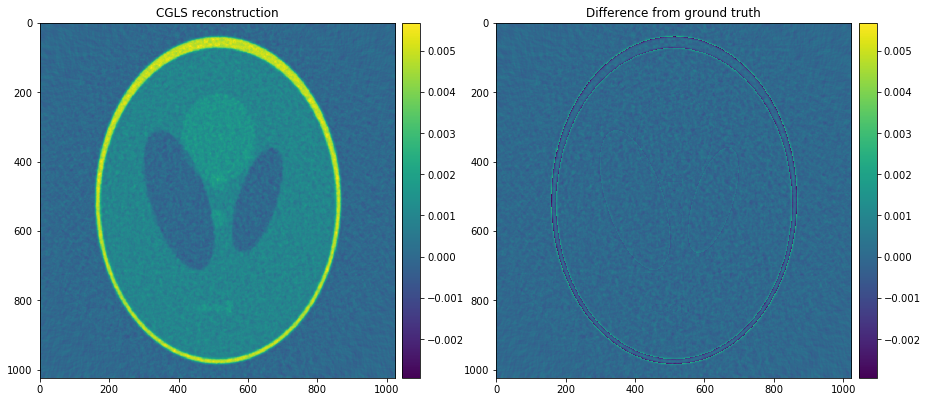

In [32]:
#plot the results
CGLS_tikhonov_output = cgls_tikhonov.get_output()

plots = [CGLS_tikhonov_output, CGLS_tikhonov_output - model]
titles = ["CGLS reconstruction","Difference from ground truth" ]
plotter2D(plots,titles,fix_range=True)

### Summary

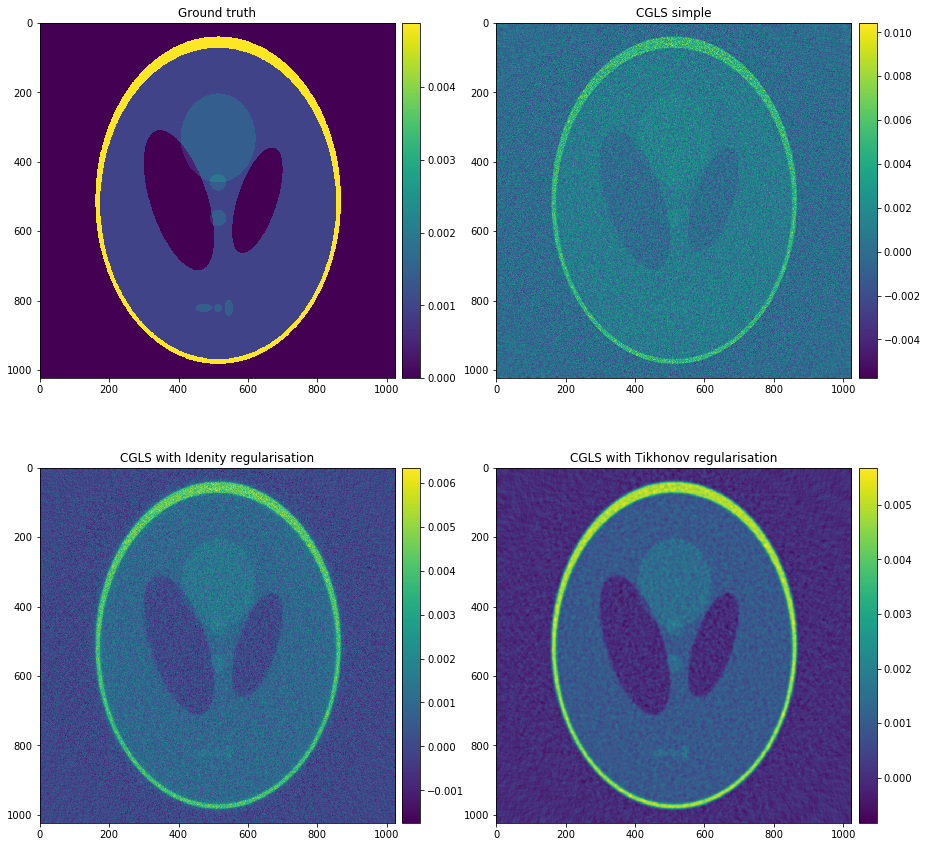

In [33]:
#compare the outputs of unregularise and regularised CGLS
plots = [model, CGLS_simple_output, CGLS_regularised_output, CGLS_tikhonov_output]
titles = ["Ground truth", "CGLS simple","CGLS with Idenity regularisation","CGLS with Tikhonov regularisation" ]
plotter2D(plots,titles,fix_range=False)